In [1]:
from scipy.integrate import solve_ivp

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.sparse import csr_matrix

In [8]:
# # Species:
# ATP = 2
# ADP = 0.
# Pi = 0.              # mM
# NADPH = 2        # mM
# NADPplus = 0.     # mM
# Lys = 0.             # mMs

# # ___________ [2, 1., 2, 1., 0.1, 0.] ___________ #
# Aspi = 2.   # No mover
# AspPi = 0.00001  # No MOVER
# ASAi = 0.00001   # NO MOVER Nivel Máximo de Thr
# HSi = 0.
# HSPi = 0.
# Thri = 0.


# Constants:
# VAKI = 0.088                # Flag 0.068
# VAKIII = 0.0094             # Flag 0.0054             
# VASD = 2                    # Flag 2
# VHDH = 10                   # Flag 10
# VHK = 45                   # Flag 100
# VTS = 10
# VATP = 0.012
# VATPII = 500

# VAKI = 0.068
# VAKIII = 0.00088
# VASD = 2
# VHDH = 10
# VHK = 100
# VTS = 10

Dado que:
$$
\begin{align*} 
\frac{d}{dt} ATP &= -V_{AK}\cdot ATP \cdot ASP \\
\frac{d}{dt} ATP &= -V_{HK} \cdot ATP \cdot HS \\
\end{align*}
$$
Entonces:

$$
\begin{align*}
\frac{d}{dt} ATP &= -V_{AK} \cdot ATP \cdot ASP -V_{HK} \cdot ATP \cdot HS \\
\frac{d}{dt} ATP &= -ATP \cdot (V_{ATP} \cdot ASP + V_{HK} \cdot HS) \\
\frac{d}{dt} ATP &= -ATP \cdot \nu_{ATP} \\
\end{align*}
$$

$$
\begin{align*}
\frac{d}{dt} Asp &= -\nu_{AKI} - \nu_{AKIII} \\
\frac{d}{dt} AspP &= \nu_{AKI} + \nu_{AKIII} - \nu_{vASD} \\
\frac{d}{dt} ASA &= \nu_{ASD} - \nu_{HDH} \\
\frac{d}{dt} HS &= \nu_{HDH} - \nu_{HK} \\
\frac{d}{dt} HSP &= \nu_{HK} - \nu_{TS} \\
\frac{d}{dt} Thr &= \nu_{TS} \\
\frac{d}{dt} ATP &= -ATP \cdot \nu_{ATP} \\
\end{align*}
$$

<!-- $$
\begin{align*} -->
# <img src="images/System.png" width=900 height=380 />
<!-- % \end{align*}
% $$ -->

In [2]:
# Species:
ADP = 0.
Pi = 0.             # mM
NADPH = 2           # mM
NADPplus = 0.       # mM
Lys = 0.            # mMs
# ___________  ___________ #
Aspi = 2.           # No mover
AspPi = 0.00001     # No MOVER
ASAi = 0.00001      # NO MOVER Nivel Máximo de Thr
HSi = 0.
HSPi = 0.
Thri = 0.
ATPi = 2.


# Constants:
VAKI = 0.088                # Flag 0.068
VAKIII = 0.0094             # Flag 0.0054             
VASD = 2                    # Flag 2
VHDH = 10                   # Flag 10
VHK = 45                   # Flag 100
VTS = 10
VATP = 0.012
VATPII = 500


# Parameters:
# - nuAKI:
KeqAK = 6.4 * pow(10, -4)
KAspAKI = 0.97              # +- 0.48 mM
KATPAKI = 0.98              # +- 0.5 mM
KAspPAKI = 0.017            # +- 0.004 mM
KADPAKI = 0.25              # mM
KiThrAKI = 0.167            # +- 0.003 mM
h1 = 4.09                   # +- 0.26
alphaAKI = 2.47             # +- 0.17


# - nuAKIII:
KeqAK = 6.4 * pow(10, -4)
KAspAKII = 0.32             # +- 0.08 mM
KATPAKIII = 0.22            # +- 0.22 mM
KAspPAKIII = 0.017          # +- 0.004 mM
KADPAKIII = 0.25            # mM
K1Lys = 0.391               # +- 0.08 mM
hlys = 2.8                  # +- 1.4


# nuASD
KeqASD = 2.84 * pow(10, 5)
KAspPASD = 0.022            # +- 0.001 mM
KNADPHASD = 0.029           # +- 0.002 mM
KASAASD = 0.11              # +- 0.008 mM
KNADPplusASD = 0.144        # +- 0.02 mM 
KPi = 10.2                  # +- 1.4 mM


# nuHDH
KeqHDH = 1 * pow(10, 11)    # M^-1
KASAHDH = 0.24              # +- 0.03 mM
KNADPHHDH = 0.037           # +- 0.006 mM
KHSHDH = 3.39               # +- 0.33 mM
KNADPplusHDH = 0.067        # +- 0.006 mM
KNADPplusAKIII = 0.067      # +- 0.006 mM == KNADPplusHDH
KiThr2 = 0.097              # mM
h2 = 1.41
alpha2 = 3.93 


# nuHK
KHSHK = 0.11        # mM
KATPHK = 0.072      # mM
KiThrHK = 1.09      # mM
KiLysHK = 9.45      # mM
KiHSHK  = 4.7       # mM
KiATPHK = 4.35      # mM

# nuTS
KHSPTS = 0.31   # +- 0.03 mM

In [3]:
def find_optimal_concentration(range_concentration=3, factor=1, constant=None, tmax=100.):
    solved_systems = []
    for i in tqdm(range(range_concentration)):
        i *= factor
        # ___________  ___________ #
        AspPi = 0.00001     
        ASAi = 0.00001      
        HSi = 0.
        HSPi = 0.
        Thri = 0.

        if constant == False:
            Aspi = 2. + i
            ATPi = 2. + i

        elif constant == 'ATP':
            Aspi = 2. + i
            ATPi = 2.
        
        elif constant == 'Asp':
            Aspi = 2.
            ATPi = 2. + i

        elif constant == True:
            Aspi = 2.
            ATPi = 2.

        solved = solve_ivp(system, [0., tmax], [Aspi, AspPi,ASAi, HSi, HSPi, Thri, ATPi])
        solved_systems.append(solved)
    return solved_systems


def system(t, r):
    Asp, AspP, ASA, HS, HSP, Thr, ATP= r
    νAKI = VAKI*(Asp*ATP - (AspP*ADP/KeqAK)) / (KAspAKI*(1 + pow((Thr/KiThrAKI), h1) / 1 + pow((Thr/alphaAKI*KiThrAKI), h1)) + AspP*((KAspAKI/KAspPAKI)) + Asp)*(KATPAKI*(1 + (ADP/KADPAKI)) + ATP)
    νAKIII = (VAKIII * (Asp * ATP - (AspP * ADP/KeqAK))) / (1 + pow((Lys/K1Lys), hlys) * (KAspAKII*(1 + (AspP/KAspPAKIII)) + Asp)  * (KATPAKIII*(1 + (ADP/KADPAKIII)) + ATP))
    νASD = VASD * (AspP * NADPH - (ASA*NADPplus * Pi / KeqASD)) / (KAspPASD * (1 + (ASA / KASAASD)) * ( 1 + (Pi / KPi)) + AspP) * (KNADPHHDH * (1 + (NADPplus/ KNADPplusASD)) + NADPH)
    νHDH = VHDH * (ASA * NADPH - (HS * NADPplus/KeqHDH)) / (1 + pow((Thr/KiThr2), h2) / 1 + pow((Thr/alpha2*KiThr2), h2)) * KASAHDH*(1 + (HS/KHSHDH) + ASA) * (KNADPHHDH * (1 + (NADPplus/KNADPplusAKIII)) + NADPH)
    νHK = VHK * HS * ATP / (KHSHK*(ATP/KiATPHK)) * (1 + (Thr/KiThrHK) + HS) * (KATPHK * (1 + (HS / KiHSHK) + ATP)) * (1 + (Lys/KiLysHK))
    νTS = VTS*HSP/KHSPTS + HSP
    νATP = VATP * Asp + VATPII*HS

    dAsp    = -νAKI - νAKIII
    dAspP   =  νAKI + νAKIII - νASD
    dASA    =  νASD - νHDH
    dHS     =  νHDH - νHK
    dHSP    =  νHK  - νTS
    dThr    =  νTS
    dATP    =  - ATP * νATP

    return np.array([dAsp, dAspP, dASA, dHS, dHSP, dThr, dATP])

solved = solve_ivp(system, [0., 100.], [Aspi, AspPi,ASAi, HSi, HSPi, Thri, ATPi])


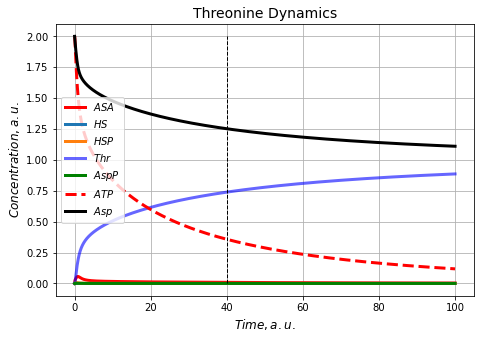

In [4]:
# figure = plt.figure(figsize=plt.figaspect(0.5))
figure = plt.figure(figsize=(7.5,5))
lw_ = 3

plt.plot(solved.t, solved.y[2], label=r'${ASA}$', color='red', lw=lw_)
plt.plot(solved.t, solved.y[3], label=r'${HS}$', lw=lw_)
plt.plot(solved.t, solved.y[4], label=r'${HSP}$', lw=lw_)
plt.plot(solved.t, solved.y[5], label=r'${Thr}$', color='blue', alpha=0.6, lw=lw_)
plt.plot(solved.t, solved.y[1], label=r'${AspP}$', color='green', lw=lw_)
plt.plot(solved.t, solved.y[6], '--',label=r'${ATP}$',color='red', lw=lw_)
plt.plot(solved.t, solved.y[0], label=r'${Asp}$', color='black', lw=lw_)

plt.legend(loc=6)
plt.grid(True)
plt.xlabel(r'${Time, a.u.}$', fontsize=12)
plt.ylabel(r'${Concentration, a.u.}$', fontsize=12)
plt.title('Threonine Dynamics', fontsize=14);
plt.vlines(40, 0, 2, colors='k', linestyles='dashed', lw=1)
plt.show()

# <img src="images/Concentration.png" width=500 height=320 />

In [5]:
factor = 10
solved_systems = find_optimal_concentration(range_concentration=12, factor=factor, constant=False, tmax=100.);

  8%|███▋                                        | 1/12 [00:01<00:15,  1.43s/it]/tmp/ipykernel_15616/3531893049.py:40: RuntimeWarning: invalid value encountered in double_scalars
  νAKI = VAKI*(Asp*ATP - (AspP*ADP/KeqAK)) / (KAspAKI*(1 + pow((Thr/KiThrAKI), h1) / 1 + pow((Thr/alphaAKI*KiThrAKI), h1)) + AspP*((KAspAKI/KAspPAKI)) + Asp)*(KATPAKI*(1 + (ADP/KADPAKI)) + ATP)
/tmp/ipykernel_15616/3531893049.py:43: RuntimeWarning: invalid value encountered in double_scalars
  νHDH = VHDH * (ASA * NADPH - (HS * NADPplus/KeqHDH)) / (1 + pow((Thr/KiThr2), h2) / 1 + pow((Thr/alpha2*KiThr2), h2)) * KASAHDH*(1 + (HS/KHSHDH) + ASA) * (KNADPHHDH * (1 + (NADPplus/KNADPplusAKIII)) + NADPH)
100%|███████████████████████████████████████████| 12/12 [04:49<00:00, 24.10s/it]


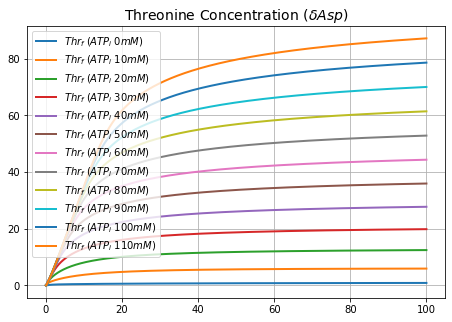

In [6]:
figure = plt.figure(figsize=(7.5,5))
[plt.plot(solved_systems[i].t, solved_systems[i].y[5], label=f'$Thr_f\;(ATP_i \; {i * factor} mM$)', lw=2) for i in range(len(solved_systems))]
plt.legend(loc=2)
plt.title(r'Threonine Concentration ($\delta{Asp})$', fontsize=14);
plt.grid(True)

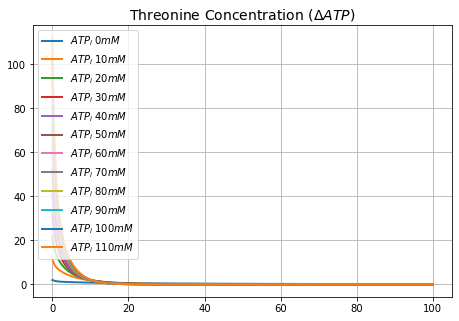

In [7]:
figure = plt.figure(figsize=(7.5,5))
[plt.plot(solved_systems[i].t, solved_systems[i].y[6], label=f'$ATP_i \;{i*factor} mM$', lw=2) for i in range(len(solved_systems))]
plt.legend(loc=2)
plt.title(r'Threonine Concentration ($\Delta{ATP})$', fontsize=14);
plt.grid(True)

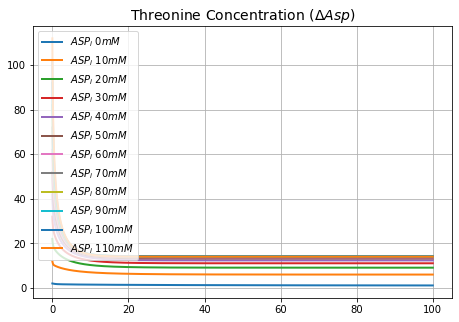

In [8]:
figure = plt.figure(figsize=(7.5,5))
[plt.plot(solved_systems[i].t, solved_systems[i].y[0], label=f'$ASP_i \;{i*factor} mM$', lw=2) for i in range(len(solved_systems))]
plt.legend(loc=2)
plt.title(r'Threonine Concentration ($\Delta{Asp})$', fontsize=14);
plt.grid(True)

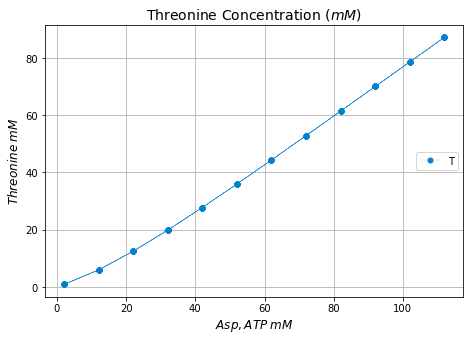

In [9]:
figure = plt.figure(figsize=(7.5,5))
x = [solved_systems[i].y[0][0] for i in range(len(solved_systems))];
y = [solved_systems[i].y[5][-1] for i in range(len(solved_systems))];
[plt.plot(x, y, '--', color='#0082D1',marker='o', lw=0.2, ms=5)  for i in range(len(solved_systems))];
plt.title(r'Threonine Concentration ($mM$)', fontsize=14);
plt.xlabel(r'${Asp, ATP}\;mM$', fontsize=12);
plt.ylabel(r'$Threonine\;mM$', fontsize=12);
plt.legend('T',loc=5);
plt.grid(True)

In [219]:
def find_optimal_constant(constants=[0.001, 0.01, 0.1, 1.], factor=1, tmax=100., delta_constants=True):
    global KiThrAKI, K1Lys, KPi, KiThr2, KiThrHK,KiLysHK, KiHSHK, KiATPHK, VAKI, VAKIII, VASD, VHDH, VHK, VTS, VATP, VATPII
    
    # Inhibition Constants:
    if delta_constants == True:
        KiThrAKI, K1Lys, KPi, KiThr2, KiThrHK,KiLysHK, KiHSHK, KiATPHK = constants
    
    elif delta_constants == 'solved':
        KiThrAKI, KiThrHK, KiATPHK = constants
        K1Lys = 0.391
        KPi = 10.2
        KiThr2 = 0.097
        KiLysHK = 9.45
        KiHSHK = 4.7
        
    # Constants:
    VAKI = 0.088                # Flag 0.068
    VAKIII = 0.0094             # Flag 0.0054             
    VASD = 2                    # Flag 2
    VHDH = 10                   # Flag 10
    VHK = 45                   # Flag 100
    VTS = 10
    VATP = 0.012
    VATPII = 500
    # KiThrAKI = 0.167                        # +- 0.003 mM   # Modify | 0.167
    # K1Lys = 0.391                           # +- 0.08 mM    # Modify | 0.391 # No tiene un impacto mayor
    # KPi = 10.2                              # +- 1.4 mM     # Modify | 10.2
    # KiThr2 = 0.097                          # mM            # Modify | 0.097
    # KiThrHK = 1.09                          # mM            # Modify | 1.09
    # KiLysHK = 9.45                          # mM            # Modify | 9.45
    # KiHSHK  = 4.7                           # mM            # Modify | 4.7
    # KiATPHK = 4.35                          # mM            # Modify | 4.35

    solved = solve_ivp(system, [0., tmax], [Aspi, AspPi,ASAi, HSi, HSPi, Thri, ATPi])
            
    return solved.y[5][-1]

In [65]:
constant_arrays = [0.167, 0.391, 10.2, 0.097, 1.09, 9.45, 4.7, 4.35]
constants = [0.08, 0.1, 0.4, 0.8, 1, 10, 30, 50, 60]

tensor = [[[constant_arrays[i] if i != j else constant_arrays[i] / m for i in range(len(constant_arrays))] for j in range(len(constant_arrays))] for m in constants]
solved_tensor = np.array([list(map(find_optimal_constant, tensor[i])) for i in tqdm(range(len(tensor)))]).T

  0%|          | 0/9 [00:00<?, ?it/s]/tmp/ipykernel_1637/1915242026.py:35: RuntimeWarning: invalid value encountered in double_scalars
  νAKI = VAKI*(Asp*ATP - (AspP*ADP/KeqAK)) / (KAspAKI*(1 + pow((Thr/KiThrAKI), h1) / 1 + pow((Thr/alphaAKI*KiThrAKI), h1)) + AspP*((KAspAKI/KAspPAKI)) + Asp)*(KATPAKI*(1 + (ADP/KADPAKI)) + ATP)
/tmp/ipykernel_1637/1915242026.py:38: RuntimeWarning: invalid value encountered in double_scalars
  νHDH = VHDH * (ASA * NADPH - (HS * NADPplus/KeqHDH)) / (1 + pow((Thr/KiThr2), h2) / 1 + pow((Thr/alpha2*KiThr2), h2)) * KASAHDH*(1 + (HS/KHSHDH) + ASA) * (KNADPHHDH * (1 + (NADPplus/KNADPplusAKIII)) + NADPH)
100%|██████████| 9/9 [05:34<00:00, 37.14s/it]


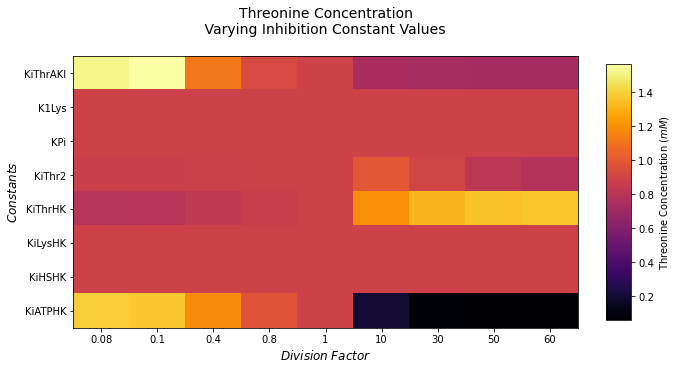

In [107]:
fig, axis = plt.subplots()

column_labels = [f'{constants[i]}' for i in range(len(constants))]
constant_names = ['KiThrAKI', 'K1Lys', 'KPi', 'KiThr2', 'KiThrHK','KiLysHK', 'KiHSHK', 'KiATPHK']

heatmap = axis.pcolor(solved_tensor, cmap=plt.cm.inferno)

axis.set_yticks(np.arange(solved_tensor.shape[0])+0.5, minor=False)
axis.set_xticks(np.arange(solved_tensor.shape[1])+0.5, minor=False)

axis.set_yticklabels(constant_names, minor=False)
axis.set_xticklabels(column_labels, minor=False)

axis.invert_yaxis()

fig.colorbar(heatmap, fraction=0.046, aspect=10, shrink=5, label='Threonine Concentration ($mM$)')
fig.set_size_inches(10, 5)

axis.set_title('Threonine Concentration\n Varying Inhibition Constant Values \n', fontsize=14);
axis.set_xlabel('$Division \; Factor$', fontsize=12);
axis.set_ylabel('$Constants$', fontsize=12);

In [145]:
kvalues = [0.167, 1.09, 4.35]
factor = 2.
values = [[kvalues[0]/(0.1 / factor * (i+1)), kvalues[1] / (i + factor), kvalues[2]/(0.1 / factor * (i+1))]for i in range(5)]
solved_constants = [find_optimal_constant(val, delta_constants='solved') for val in tqdm(values)];

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_1637/1915242026.py:35: RuntimeWarning: invalid value encountered in double_scalars
  νAKI = VAKI*(Asp*ATP - (AspP*ADP/KeqAK)) / (KAspAKI*(1 + pow((Thr/KiThrAKI), h1) / 1 + pow((Thr/alphaAKI*KiThrAKI), h1)) + AspP*((KAspAKI/KAspPAKI)) + Asp)*(KATPAKI*(1 + (ADP/KADPAKI)) + ATP)
/tmp/ipykernel_1637/1915242026.py:38: RuntimeWarning: invalid value encountered in double_scalars
  νHDH = VHDH * (ASA * NADPH - (HS * NADPplus/KeqHDH)) / (1 + pow((Thr/KiThr2), h2) / 1 + pow((Thr/alpha2*KiThr2), h2)) * KASAHDH*(1 + (HS/KHSHDH) + ASA) * (KNADPHHDH * (1 + (NADPplus/KNADPplusAKIII)) + NADPH)
100%|██████████| 5/5 [09:33<00:00, 114.71s/it]


Optimal Ki values: 
KiThrAKI: 1.67 
KiThrHK: 0.36333333333333334 
KiATPHK: 43.49999999999999
Maximum Threonine Synthesis: 1.9995618365558117
Minimum Threonine Synthesis: 1.8605341249010636


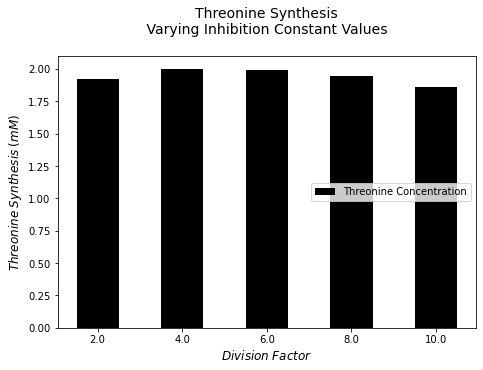

In [253]:
figure = plt.figure(figsize=(7.5,5))
K_val = values[np.argmax(solved_constants)]
print(f'Optimal Ki values: \nKiThrAKI: {K_val[0]} \nKiThrHK: {K_val[1]} \nKiATPHK: {K_val[2]}')
print(f'Maximum Threonine Synthesis: {np.max(solved_constants)}')
print(f'Minimum Threonine Synthesis: {np.min(solved_constants)}')

plt.bar(range(1, 6), solved_constants, color='black', width=0.5, align='center', label='Threonine Concentration');
plt.title('Threonine Synthesis\n Varying Inhibition Constant Values \n', fontsize=14);
plt.xlabel('$Division \; Factor$', fontsize=12);
plt.ylabel('$Threonine\;Synthesis\;(mM)$', fontsize=12);
plt.legend(loc=5);
# plt.yscale('log')
plt.xticks(range(1, 6), [f'{round(factor * (i+1), 4)}' for i in range(5)]);
# plt.vlines(np.argmax(solved_constants), 1.85, np.max(solved_constants), color='red', lw=0.5);

In [239]:
def find_optimal_velocity(constants=[0.088, 0.0094, 10, 45, 0.012, 500.], factor=1, tmax=100., delta_constants=True):
    global VAKI, VAKIII, VHDH, VHK, VATP, VATPII, KiThrAKI, K1Lys, KPi, KiThr2, KiThrHK, KiLysHK, KiHSHK, KiATPHK
    # Velocity Constants:
    KiThrAKI = 0.167                        # +- 0.003 mM   # Modify | 0.167
    K1Lys = 0.391                           # +- 0.08 mM    # Modify | 0.391 # No tiene un impacto mayor
    KPi = 10.2                              # +- 1.4 mM     # Modify | 10.2
    KiThr2 = 0.097                          # mM            # Modify | 0.097
    KiThrHK = 1.09                          # mM            # Modify | 1.09
    KiLysHK = 9.45                          # mM            # Modify | 9.45
    KiHSHK  = 4.7                           # mM            # Modify | 4.7
    KiATPHK = 4.35                          # mM            # Modify | 4.35
    if delta_constants == True:
        VAKI, VAKIII, VHDH, VHK, VATP, VATPII= constants
    
    elif delta_constants == 'solved':
        VAKIII, VHK, VATP, VATPII = constants
        VAKI = 0.088                # Flag 0.068            
        VHDH = 10.                   # Flag 10

    solved = solve_ivp(system, [0., tmax], [Aspi, AspPi,ASAi, HSi, HSPi, Thri, ATPi])
            
    return solved.y[5][-1]

In [240]:
constant_arrays_v = [0.088, 0.0094, 10, 45, 0.012, 500.]
constants_v = [0.08, 0.1, 0.2, 0.4, 0.6, 0.8, 1. , 1.1, 1.2, 1.4 , 1.6 , 1.8, 2., 4., 8., 16.]

tensor_v = [[[constant_arrays_v[i] if i != j else constant_arrays_v[i] / m for i in range(len(constant_arrays_v))] for j in range(len(constant_arrays_v))] for m in constants_v]
solved_tensor_v = np.array([list(map(find_optimal_velocity, tensor_v[i])) for i in tqdm(range(len(tensor_v)))]).T

  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_1637/1915242026.py:35: RuntimeWarning: invalid value encountered in double_scalars
  νAKI = VAKI*(Asp*ATP - (AspP*ADP/KeqAK)) / (KAspAKI*(1 + pow((Thr/KiThrAKI), h1) / 1 + pow((Thr/alphaAKI*KiThrAKI), h1)) + AspP*((KAspAKI/KAspPAKI)) + Asp)*(KATPAKI*(1 + (ADP/KADPAKI)) + ATP)
/tmp/ipykernel_1637/1915242026.py:38: RuntimeWarning: invalid value encountered in double_scalars
  νHDH = VHDH * (ASA * NADPH - (HS * NADPplus/KeqHDH)) / (1 + pow((Thr/KiThr2), h2) / 1 + pow((Thr/alpha2*KiThr2), h2)) * KASAHDH*(1 + (HS/KHSHDH) + ASA) * (KNADPHHDH * (1 + (NADPplus/KNADPplusAKIII)) + NADPH)
100%|██████████| 16/16 [04:56<00:00, 18.55s/it]


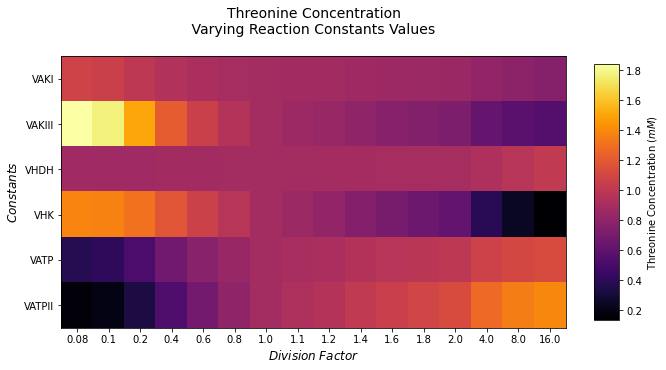

In [241]:
fig, axis = plt.subplots()

column_labels = [f'{constants_v[i]}' for i in range(len(constants_v))]
constant_names = ['VAKI', 'VAKIII', 'VHDH', 'VHK', 'VATP', 'VATPII']

heatmap = axis.pcolor(solved_tensor_v, cmap=plt.cm.inferno)

axis.set_yticks(np.arange(solved_tensor_v.shape[0])+0.5, minor=False)
axis.set_xticks(np.arange(solved_tensor_v.shape[1])+0.5, minor=False)

axis.set_yticklabels(constant_names, minor=False)
axis.set_xticklabels(column_labels, minor=False)

axis.invert_yaxis()

fig.colorbar(heatmap, fraction=0.046, aspect=10, shrink=5, label='Threonine Concentration ($mM$)')
fig.set_size_inches(10, 5)

axis.set_title('Threonine Concentration\n Varying Reaction Constants Values \n', fontsize=14);
axis.set_xlabel('$Division \; Factor$', fontsize=12);
axis.set_ylabel('$Constants$', fontsize=12);

In [275]:
# VAKIII, VHK, VATP, VATPII
# VAKI = 0.088                # Flag 0.068
# VAKIII = 0.0094             # Flag 0.0054             
# VASD = 2                    # Flag 2
# VHDH = 10                   # Flag 10
# VHK = 45                   # Flag 100
# VTS = 10
# VATP = 0.012
# VATPII = 500
kvalues_v = [0.088, 45, 0.012, 500.]
factor_v = 1.
assays_v = 8
values_v = [[kvalues_v[0]/factor_v * (i + 0.1), kvalues_v[1]/ factor_v * (i + 0.1), kvalues_v[2]/factor * (i + 1), kvalues_v[3]/factor * (i + 1),]for i in range(assays_v)]
solved_constants_v = [find_optimal_velocity(val, delta_constants='solved') for val in tqdm(values_v)];

100%|██████████| 8/8 [01:31<00:00, 11.42s/it]


Optimal V values: 
VAKIII: 0.6247999999999999 
VHK: 319.5 
VATP: 0.048, 
VATPII: 2000.0
Maximum Threonine Synthesis: 2.0000192326503234
Minimum Threonine Synthesis: 0.3493975903070692


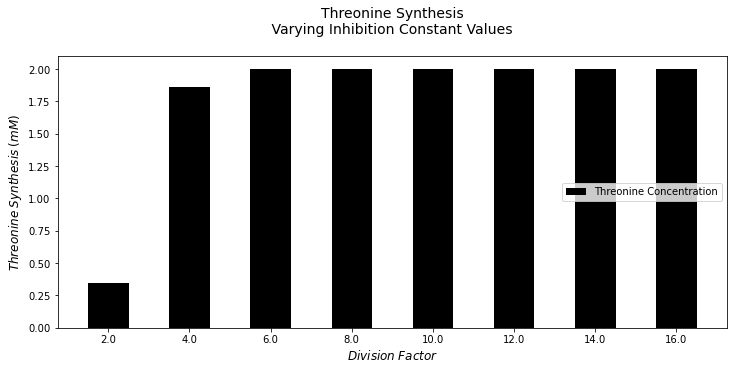

In [276]:
# VAKIII, VHK, VATP, VATPII
figure = plt.figure(figsize=(12,5))
K_val = values_v[np.argmax(solved_constants_v)]
print(f'Optimal V values: \nVAKIII: {K_val[0]} \nVHK: {K_val[1]} \nVATP: {K_val[2]}, \nVATPII: {K_val[3]}')
print(f'Maximum Threonine Synthesis: {np.max(solved_constants_v)}')
print(f'Minimum Threonine Synthesis: {np.min(solved_constants_v)}')

plt.bar(range(assays_v), solved_constants_v, color='black', width=0.5, align='center', label='Threonine Concentration');
plt.title('Threonine Synthesis\n Varying Inhibition Constant Values \n', fontsize=14);
plt.xlabel('$Division \; Factor$', fontsize=12);
plt.ylabel('$Threonine\;Synthesis\;(mM)$', fontsize=12);
plt.legend(loc=5);
plt.xticks(range(assays_v), [f'{round(factor * (i+1), 4)}' for i in range(assays_v)]);

In [24]:
def system(t, r):
    Asp, AspP, ASA, HS, HSP, Thr, ATP = r
    νAKI = VAKI*(Asp*ATP - (AspP*ADP/KeqAK)) / (KAspAKI*(1 + pow((Thr/KiThrAKI), h1) / 1 + pow((Thr/alphaAKI*KiThrAKI), h1)) + AspP*((KAspAKI/KAspPAKI)) + Asp)*(KATPAKI*(1 + (ADP/KADPAKI)) + ATP)
    νAKIII = (VAKIII * (Asp * ATP - (AspP * ADP/KeqAK))) / (1 + pow((Lys/K1Lys), hlys) * (KAspAKII*(1 + (AspP/KAspPAKIII)) + Asp)  * (KATPAKIII*(1 + (ADP/KADPAKIII)) + ATP))
    νASD = VASD * (AspP * NADPH - (ASA*NADPplus * Pi / KeqASD)) / (KAspPASD * (1 + (ASA / KASAASD)) * ( 1 + (Pi / KPi)) + AspP) * (KNADPHHDH * (1 + (NADPplus/ KNADPplusASD)) + NADPH)
    νHDH = VHDH * (ASA * NADPH - (HS * NADPplus/KeqHDH)) / (1 + pow((Thr/KiThr2), h2) / 1 + pow((Thr/alpha2*KiThr2), h2)) * KASAHDH*(1 + (HS/KHSHDH) + ASA) * (KNADPHHDH * (1 + (NADPplus/KNADPplusAKIII)) + NADPH)
    νHK = VHK * HS * ATP / (KHSHK*(ATP/KiATPHK)) * (1 + (Thr/KiThrHK) + HS) * (KATPHK * (1 + (HS / KiHSHK) + ATP)) * (1 + (Lys/KiLysHK))
    νTS = VTS*HSP/KHSPTS + HSP
    νATP = VATP * Asp + VATPII*HS

    dAsp    = -νAKI - νAKIII
    dAspP   =  νAKI + νAKIII - νASD
    dASA    =  νASD - νHDH
    dHS     =  νHDH - νHK
    dHSP    =  νHK  - νTS
    dThr    =  νTS
    dATP    =  - ATP * νATP

    return np.array([dAsp, dAspP, dASA, dHS, dHSP, dThr, dATP])


solved = solve_ivp(system, [0., 100.], [Aspi, AspPi,ASAi, HSi, HSPi, Thri, ATPi])

In [52]:
from scipy.optimize import least_squares

In [56]:
def system(r):
    Asp, AspP, ASA, HS, HSP, Thr, ATP = r
    νAKI = VAKI*(Asp*ATP - (AspP*ADP/KeqAK)) / (KAspAKI*(1 + pow((Thr/KiThrAKI), h1) / 1 + pow((Thr/alphaAKI*KiThrAKI), h1)) + AspP*((KAspAKI/KAspPAKI)) + Asp)*(KATPAKI*(1 + (ADP/KADPAKI)) + ATP)
    νAKIII = (VAKIII * (Asp * ATP - (AspP * ADP/KeqAK))) / (1 + pow((Lys/K1Lys), hlys) * (KAspAKII*(1 + (AspP/KAspPAKIII)) + Asp)  * (KATPAKIII*(1 + (ADP/KADPAKIII)) + ATP))
    νASD = VASD * (AspP * NADPH - (ASA*NADPplus * Pi / KeqASD)) / (KAspPASD * (1 + (ASA / KASAASD)) * ( 1 + (Pi / KPi)) + AspP) * (KNADPHHDH * (1 + (NADPplus/ KNADPplusASD)) + NADPH)
    νHDH = VHDH * (ASA * NADPH - (HS * NADPplus/KeqHDH)) / (1 + pow((Thr/KiThr2), h2) / 1 + pow((Thr/alpha2*KiThr2), h2)) * KASAHDH*(1 + (HS/KHSHDH) + ASA) * (KNADPHHDH * (1 + (NADPplus/KNADPplusAKIII)) + NADPH)
    νHK = VHK * HS * ATP / (KHSHK*(ATP/KiATPHK)) * (1 + (Thr/KiThrHK) + HS) * (KATPHK * (1 + (HS / KiHSHK) + ATP)) * (1 + (Lys/KiLysHK))
    νTS = VTS*HSP/KHSPTS + HSP
    νATP = VATP * Asp + VATPII*HS

    dAsp    = -νAKI - νAKIII
    dAspP   =  νAKI + νAKIII - νASD
    dASA    =  νASD - νHDH
    dHS     =  νHDH - νHK
    dHSP    =  νHK  - νTS
    dThr    =  νTS
    dATP    =  - ATP * νATP

    return np.array([dAsp, dAspP, dASA, dHS, dHSP, dThr, dATP])

yuca = least_squares(system, np.array([1, 1, 1, 1, 1, 1, 1]))

In [58]:
yuca.x

array([ 2.57269125e-14,  6.51954471e-21, -9.99999919e-01,  6.67205696e-17,
        3.18766224e-21,  1.26648802e+02,  5.51773352e-03])

In [27]:
import sympy as sy

In [28]:
Asp, AspP, ASA, HS, HSP, Thr, ATP = sy.symbols('Asp AspP ASA HS HSP Thr ATP')
νAKI = VAKI*(Asp*ATP - (AspP*ADP/KeqAK)) / (KAspAKI*(1 + pow((Thr/KiThrAKI), h1) / 1 + pow((Thr/alphaAKI*KiThrAKI), h1)) + AspP*((KAspAKI/KAspPAKI)) + Asp)*(KATPAKI*(1 + (ADP/KADPAKI)) + ATP)
νAKIII = (VAKIII * (Asp * ATP - (AspP * ADP/KeqAK))) / (1 + pow((Lys/K1Lys), hlys) * (KAspAKII*(1 + (AspP/KAspPAKIII)) + Asp)  * (KATPAKIII*(1 + (ADP/KADPAKIII)) + ATP))
νASD = VASD * (AspP * NADPH - (ASA*NADPplus * Pi / KeqASD)) / (KAspPASD * (1 + (ASA / KASAASD)) * ( 1 + (Pi / KPi)) + AspP) * (KNADPHHDH * (1 + (NADPplus/ KNADPplusASD)) + NADPH)
νHDH = VHDH * (ASA * NADPH - (HS * NADPplus/KeqHDH)) / (1 + pow((Thr/KiThr2), h2) / 1 + pow((Thr/alpha2*KiThr2), h2)) * KASAHDH*(1 + (HS/KHSHDH) + ASA) * (KNADPHHDH * (1 + (NADPplus/KNADPplusAKIII)) + NADPH)
νHK = VHK * HS * ATP / (KHSHK*(ATP/KiATPHK)) * (1 + (Thr/KiThrHK) + HS) * (KATPHK * (1 + (HS / KiHSHK) + ATP)) * (1 + (Lys/KiLysHK))
νTS = VTS*HSP/KHSPTS + HSP
νATP = VATP * Asp + VATPII*HS

In [29]:
X = sy.Matrix([-νAKI - νAKIII, νAKI + νAKIII - νASD, νASD - νHDH, νHDH - νHK, νHK  - νTS, νTS, - ATP * νATP])
X

Matrix([
[                                                                -0.088*ATP*Asp*(ATP + 0.98)/(Asp + 57.0588235294118*AspP + 1465.08010864367*Thr**4.09 + 0.97) - 0.0094*ATP*Asp],
[                           0.088*ATP*Asp*(ATP + 0.98)/(Asp + 57.0588235294118*AspP + 1465.08010864367*Thr**4.09 + 0.97) + 0.0094*ATP*Asp - 8.148*AspP/(0.2*ASA + AspP + 0.022)],
[                                                           -9.7776*ASA*(ASA + 0.294985250737463*HS + 1)/(26.8373371575812*Thr**1.41 + 1) + 8.148*AspP/(0.2*ASA + AspP + 0.022)],
[9.7776*ASA*(ASA + 0.294985250737463*HS + 1)/(26.8373371575812*Thr**1.41 + 1) - 1779.54545454545*HS*(0.072*ATP + 0.0153191489361702*HS + 0.072)*(HS + 0.91743119266055*Thr + 1)],
[                                                         1779.54545454545*HS*(0.072*ATP + 0.0153191489361702*HS + 0.072)*(HS + 0.91743119266055*Thr + 1) - 33.258064516129*HSP],
[                                                                                                    

In [31]:
Y = sy.Matrix([Asp, AspP, ASA, HS, HSP, Thr, ATP])
Y

Matrix([
[ Asp],
[AspP],
[ ASA],
[  HS],
[ HSP],
[ Thr],
[ ATP]])

In [34]:
jacob = X.jacobian(Y)
jacob

Matrix([
[ 4.09977410643112e-8*ATP*Asp*(ATP + 0.98)/(0.000682556533325522*Asp + 0.038945872783868*AspP + Thr**4.09 + 0.000662079837325756)**2 - 0.088*ATP*(ATP + 0.98)/(Asp + 57.0588235294118*AspP + 1465.08010864367*Thr**4.09 + 0.97) - 0.0094*ATP,                                                                            2.33928287249305e-6*ATP*Asp*(ATP + 0.98)/(0.000682556533325522*Asp + 0.038945872783868*AspP + Thr**4.09 + 0.000662079837325756)**2,                                                                                                                                                                 0,                                                                                                                                                                                                                                                                                           0,                0,                          0.000245665747474522*ATP*Asp*Thr**3.09*(ATP + 0.98)/(0.

In [41]:
Asp, AspP, ASA, HS, HSP, Thr, ATP = 1, 1, 1, 1, 1, 1, 1

In [47]:
sy.N(jacob, )

Matrix([
[ 4.0e-8*ATP*Asp*(ATP + 1.0)/(0.0007*Asp + 0.04*AspP + Thr**4.0 + 0.0007)**2 - 0.09*ATP*(ATP + 1.0)/(Asp + 6.0e+1*AspP + 1.0e+3*Thr**4.0 + 1.0) - 0.009*ATP,                                                                      2.0e-6*ATP*Asp*(ATP + 1.0)/(0.0007*Asp + 0.04*AspP + Thr**4.0 + 0.0007)**2,                                                                                                                               0,                                                                                                                                                                         0,     0,                 0.0002*ATP*Asp*Thr**3.0*(ATP + 1.0)/(0.0007*Asp + 0.04*AspP + Thr**4.0 + 0.0007)**2, -0.09*ATP*Asp/(Asp + 6.0e+1*AspP + 1.0e+3*Thr**4.0 + 1.0) - 0.09*Asp*(ATP + 1.0)/(Asp + 6.0e+1*AspP + 1.0e+3*Thr**4.0 + 1.0) - 0.009*Asp],
[-4.0e-8*ATP*Asp*(ATP + 1.0)/(0.0007*Asp + 0.04*AspP + Thr**4.0 + 0.0007)**2 + 0.09*ATP*(ATP + 1.0)/(Asp + 6.0e+1*AspP + 1.0e+3*Thr**4.0 + 1.0